In [ ]:
!pip install convokit

In [ ]:
!pip install unsloth

In [ ]:
# Load the winning arguments corpus
# import unsloth
from convokit import Corpus, download, Coordination


In [ ]:
pip show convokit

In [ ]:
print("Loading CMV data...")
corpus = Corpus(filename=download("winning-args-corpus"))

In [ ]:
print(corpus.meta)

ConvoKitMeta({'name': 'Winning Arguments - Change My View Corpus'})


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from convokit import Corpus, download, Coordination
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class CMVDataFilter:
    """
    Implements the exact filtering used in the original "Winning Arguments" paper
    """

    def __init__(self, corpus):
        self.corpus = corpus
        self.filtered_conversations = []
        self.valid_utterance_ids = set(corpus.get_utterance_ids())

    def check_conversation_integrity(self, conversation):
        """Check if conversation has all required utterances"""
        missing_utterances = []

        for utt_id in conversation.get_utterance_ids():
            if utt_id not in self.valid_utterance_ids:
                missing_utterances.append(utt_id)

        return len(missing_utterances) == 0, missing_utterances

    def count_challengers_and_replies(self, conversation):
        """Count unique challengers and OP replies in conversation"""
        # Get OP username from conversation metadata
        op_username = conversation.meta.get('op-userID', None)
        if not op_username:
            return 0, 0, []

        challengers = set()
        op_reply_count = 0
        root_replies = []

        try:
            for utt_id in conversation.get_utterance_ids():
                utterance = self.corpus.get_utterance(utt_id)

                # Skip if utterance has missing text or author
                if not utterance.text or utterance.speaker.id in ['[missing]', '[deleted]']:
                    continue

                # Check if this is a root reply (direct reply to OP)
                if (utterance.reply_to == conversation.id and
                    utterance.speaker.id != op_username):

                    challengers.add(utterance.speaker.id)

                    # Check minimum word count (50+ words as per paper)
                    if len(utterance.text.split()) >= 50:
                        root_replies.append(utterance)

                # Count OP replies
                elif utterance.speaker.id == op_username and utterance.id != conversation.id:
                    op_reply_count += 1

        except KeyError:
            # Handle missing utterances gracefully
            return 0, 0, []

        return len(challengers), op_reply_count, root_replies

    def filter_corpus(self):
        """
        Apply all filters from the original paper:
        1. At least 10 challengers
        2. At least 1 OP reply
        3. Root replies have 50+ words
        4. Complete conversation threads (no missing utterances)
        """

        print("Filtering corpus using original paper criteria...")
        print(f"Original conversations: {len(list(self.corpus.iter_conversations()))}")

        valid_conversations = []

        for conversation in self.corpus.iter_conversations():
            # Check 1: Conversation integrity (no missing utterances)
            is_complete, missing = self.check_conversation_integrity(conversation)
            if not is_complete:
                continue

            # Check 2: Count challengers and OP replies
            num_challengers, num_op_replies, root_replies = self.count_challengers_and_replies(conversation)

            # Apply paper's criteria
            if (num_challengers >= 10 and
                num_op_replies >= 1 and
                len(root_replies) >= 3):  # At least 3 substantial root replies

                valid_conversations.append(conversation)

        print(f"Filtered conversations: {len(valid_conversations)}")
        print(f"Retention rate: {len(valid_conversations)/len(list(self.corpus.iter_conversations()))*100:.1f}%")

        self.filtered_conversations = valid_conversations
        return valid_conversations

In [ ]:
class CMVFeatureExtractor:
    """ConvoKit-based feature extraction with proper filtering"""

    def __init__(self, corpus):
        self.corpus = corpus
        self.filtered_conversations = []

    def setup_coordination_analysis(self):
        """Use ConvoKit's Coordination class for linguistic interplay - with filtering"""
        print("Setting up ConvoKit coordination analysis...")

        # Step 1: Filter corpus first
        data_filter = CMVDataFilter(self.corpus)
        self.filtered_conversations = data_filter.filter_corpus()

        if not self.filtered_conversations:
            raise ValueError("No conversations passed filtering criteria")

        # Step 2: Create filtered corpus for coordination analysis
        print("Creating filtered corpus for coordination analysis...")

        # Get all utterance IDs from filtered conversations
        filtered_utterance_ids = set()
        for conv in self.filtered_conversations:
            for utt_id in conv.get_utterance_ids():
                try:
                    # Verify utterance exists and is accessible
                    utt = self.corpus.get_utterance(utt_id)
                    if utt.text and utt.speaker.id not in ['[missing]', '[deleted]']:
                        filtered_utterance_ids.add(utt_id)
                except KeyError:
                    continue

        print(f"Using {len(filtered_utterance_ids)} utterances for coordination analysis")

        # Step 3: Run coordination analysis safely
        try:
            self.coord = Coordination()
            self.coord.fit(self.corpus)
            self.corpus = self.coord.transform(self.corpus)
            print("Coordination analysis completed successfully!")

        except Exception as e:
            print(f"Coordination analysis failed: {e}")
            print("Using fallback: coordination scores will be set to 0.0")
            self.coord = None

    def extract_features(self):
        """Extract features from filtered conversations only"""
        features = []
        labels = []

        processed_count = 0
        skipped_count = 0

        print("Extracting features from filtered conversations...")

        for conversation in self.filtered_conversations:
            try:
                for utt_id in conversation.get_utterance_ids():
                    try:
                        utterance = self.corpus.get_utterance(utt_id)
                        success_label = utterance.meta.get('success')

                        if success_label is not None:
                            # Feature 1: Linguistic interplay (from ConvoKit Coordination)
                            if self.coord is not None:
                                # Try to get coordination data
                                coord_data = utterance.meta.get('coord', {})
                                if coord_data:
                                    interplay = coord_data.get('score', 0.0)
                                    interplay = max(0.0, min(1.0, interplay))  # Normalize to 0-1
                                else:
                                    interplay = 0.0
                            else:
                                interplay = 0.0

                            # Feature 2: Comment length (normalized)
                            length_norm = min(1.0, len(utterance.text.split()) / 200.0)

                            features.append([interplay, length_norm])
                            labels.append(float(success_label))  # 0.0 or 1.0
                            processed_count += 1

                    except KeyError:
                        skipped_count += 1
                        continue

            except Exception as e:
                skipped_count += 1
                continue

        print(f"Successfully extracted {processed_count} features")
        print(f"Skipped {skipped_count} problematic utterances")

        if processed_count == 0:
            raise ValueError("No valid features extracted after filtering")

        return np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)

In [ ]:
# Architecture:

class CMVPredictor(nn.Module):
    """
    REGRESSION VERSION - Outputs continuous persuasion scores 0.0-1.0

    Current: 2 → 4 → 1 (very simple)

    TRY EXPERIMENTING WITH:
    - Different hidden layer sizes: 8, 16, 32
    - More layers: 2 → 8 → 4 → 1
    - Different activation functions: Tanh, LeakyReLU
    - Add dropout: nn.Dropout(0.2)
    - Add batch normalization: nn.BatchNorm1d()
    """

    def __init__(self, hidden_size=4):
        super().__init__()

        # REGRESSION ARCHITECTURE (no final sigmoid!)
        self.network = nn.Sequential(
            nn.Linear(2, hidden_size),        # Was 2 features → 4 hidden
            nn.ReLU(),
            nn.Linear(hidden_size, 1),        # Was 4 hidden → 1 output
            # Previus remark: NO SIGMOID - outputs raw scores!
        )

    def forward(self, x):
        return torch.clamp(self.network(x), 0, 1)  # Force 0-1 range


In [ ]:
# Learning:

class CMVTrainer:
    """
    BASIC TRAINER - YOU SHOULD EXPERIMENT WITH THIS!
    """

    def __init__(self, model):
        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # EXPERIMENT 2: Regression loss function
        self.criterion = nn.MSELoss()               # Mean Squared Error for regression
        # Alternative: nn.L1Loss() (Mean Absolute Error) - try both!

        # EXPERIMENT 3: Try different optimizers and learning rates
        self.optimizer = optim.Adam(                # TODO: Try SGD, RMSprop
            model.parameters(),
            lr=0.001                                # TODO: Try 0.01, 0.0001, 0.1
        )

        # Track metrics for analysis
        self.train_losses = []
        self.val_losses = []
        self.val_maes = []  # Mean Absolute Error instead of accuracy

    def prepare_data(self, features, labels, test_size=0.2, batch_size=32):
        """Data preparation - you can experiment with batch sizes"""
        X_train, X_val, y_train, y_val = train_test_split(
            features, labels, test_size=test_size, random_state=42, stratify=labels
        )

        # EXPERIMENT 4: Try with/without standardization
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)

        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled)
        y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val_scaled)
        y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Success rate: {np.mean(labels)*100:.1f}%")

    def train_one_epoch(self):
        """Single training epoch"""
        self.model.train()
        epoch_loss = 0.0

        for batch_features, batch_labels in self.train_loader:
            batch_features = batch_features.to(self.device)
            batch_labels = batch_labels.to(self.device)

            # Forward pass
            predictions = self.model(batch_features)
            loss = self.criterion(predictions, batch_labels)

            # Backward pass (automatic differentiation!)
            self.optimizer.zero_grad()
            loss.backward()  # This computes ALL gradients automatically
            self.optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(self.train_loader)

    def validate(self):
      """Validation step"""
      self.model.eval()
      val_loss = 0.0
      total_mae = 0.0
      total_samples = 0

      with torch.no_grad():
          for batch_features, batch_labels in self.val_loader:
              batch_features = batch_features.to(self.device)
              batch_labels = batch_labels.to(self.device)

              predictions = self.model(batch_features)
              loss = self.criterion(predictions, batch_labels)
              val_loss += loss.item()

              # Calculate MAE (Mean Absolute Error) instead of accuracy
              mae = torch.mean(torch.abs(predictions - batch_labels))
              total_mae += mae.item() * batch_labels.size(0)
              total_samples += batch_labels.size(0)

      avg_mae = total_mae / total_samples
      return val_loss / len(self.val_loader), avg_mae

    def train(self, epochs=50):
        """
        BASIC TRAINING LOOP - YOU CAN IMPROVE THIS!

        EXPERIMENT 5: Add improvements like:
        - Early stopping
        - Learning rate scheduling
        - Model checkpointing
        - Different validation metrics
        """
        print(f"Training for {epochs} epochs...")

        for epoch in range(epochs):
            train_loss = self.train_one_epoch()
            val_loss, val_mae = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_maes.append(val_mae)

            if epoch % 10 == 0 or epoch < 5:
                print(f"Epoch {epoch:2d}: Train Loss = {train_loss:.4f}, "
                      f"Val Loss = {val_loss:.4f}, Val MAE = {val_mae:.3f}")

        print("Training complete!")
        return self.train_losses, self.val_losses, self.val_maes

In [ ]:
def compare_architectures():
    """
    Compare different hidden layer sizes systematically
    """

    print("=== CMV Architecture Comparison ===")

    print("Extracting features...")
    extractor = CMVFeatureExtractor(corpus)
    extractor.setup_coordination_analysis()
    features, labels = extractor.extract_features()

    print(f"Dataset: {len(features)} samples, {len(features[0])} features")

    # 2. Test different architectures
    architectures = [4, 8, 16, 32]  # Start with these
    results = {}

    for hidden_size in architectures:
        print(f"\n--- Testing {hidden_size} hidden neurons ---")

        # Create model with different hidden size
        model = CMVPredictor(hidden_size=hidden_size)  # Uses your modified class
        print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

        # Train (shorter epochs for comparison)
        trainer = CMVTrainer(model)
        trainer.prepare_data(features, labels)
        train_losses, val_losses, val_maes = trainer.train(epochs=20)  # Shorter for comparison

        # Store results
        results[hidden_size] = {
            'final_mae': val_maes[-1],
            'best_mae': min(val_maes),
            'final_val_loss': val_losses[-1],
            'trainer': trainer
        }

        print(f"Final MAE: {val_maes[-1]:.3f}, Best MAE: {min(val_maes):.3f}")

    # 3. Show comparison table
    print("\n=== ARCHITECTURE COMPARISON RESULTS ===")
    print("Hidden Size | Final MAE | Best MAE  | Parameters")
    print("-" * 45)
    for size, metrics in results.items():
        params = (2 * size) + (size * 1) + size + 1  # Calculate parameter count
        print(f"{size:10d} | {metrics['final_mae']:8.3f} | {metrics['best_mae']:8.3f} | {params:9d}")

    # 4. Find best architecture
    best_size = min(results.keys(), key=lambda x: results[x]['best_mae'])
    print(f"\nBest architecture: {best_size} hidden neurons")
    print(f"Best MAE: {results[best_size]['best_mae']:.3f}")

    return results, best_size

In [ ]:
def run_basic_experiment():
    """
    BASIC EXPERIMENT - YOU SHOULD MODIFY AND IMPROVE THIS!
    """

    print("=== CMV Basic Experiment ===")

    # 1. Load data
    # Moved it to 'compare architectures'

    # 2. Extract features using ConvoKit
    print("Extracting features...")
    extractor = CMVFeatureExtractor(corpus)
    extractor.setup_coordination_analysis()
    features, labels = extractor.extract_features()

    print(f"Dataset: {len(features)} samples, {len(features[0])} features")

    # 3. Create and train model
    print("Creating model...")
    model = CMVPredictor()
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

    print("Training...")
    trainer = CMVTrainer(model)
    trainer.prepare_data(features, labels)
    train_losses, val_losses, val_maes = trainer.train(epochs=50)

    # 4. Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_maes, label='Validation MAE', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Validation MAE (lower is better)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Final validation MAE: {val_maes[-1]:.3f}")

    return model, trainer

In [ ]:
def analyze_predictions(model, trainer):
    """Analyze what the model learned"""
    model.eval()

    # Get predictions on validation set
    all_predictions = []
    all_labels = []
    all_features = []

    with torch.no_grad():
        for batch_features, batch_labels in trainer.val_loader:
            batch_features = batch_features.to(trainer.device)
            predictions = model(batch_features)

            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(batch_labels.cpu().numpy().flatten())
            all_features.extend(batch_features.cpu().numpy())

    all_features = np.array(all_features)

    # Plot analysis
    plt.figure(figsize=(15, 10))

    # Plot 1: Predictions vs True Labels
    plt.subplot(2, 3, 1)
    plt.scatter(all_labels, all_predictions, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
    plt.xlabel('True Labels (Success)')
    plt.ylabel('Model Predictions')
    plt.title('Predictions vs True Labels')
    plt.legend()
    plt.grid(True)

    # Plot 2: Distribution comparison
    plt.subplot(2, 3, 2)
    plt.hist(all_predictions, bins=20, alpha=0.7, label='Predictions', density=True)
    plt.hist(all_labels, bins=20, alpha=0.7, label='True Labels', density=True)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution: Predictions vs Labels')
    plt.legend()
    plt.grid(True)

    # Plot 3: Feature 1 (Linguistic Interplay) vs Predictions
    plt.subplot(2, 3, 3)
    plt.scatter(all_features[:, 0], all_predictions, alpha=0.5, c=all_labels, cmap='viridis')
    plt.xlabel('Feature 1: Linguistic Interplay')
    plt.ylabel('Model Predictions')
    plt.title('Interplay vs Predictions')
    plt.colorbar(label='True Success')
    plt.grid(True)

    # Plot 4: Feature 2 (Comment Length) vs Predictions
    plt.subplot(2, 3, 4)
    plt.scatter(all_features[:, 1], all_predictions, alpha=0.5, c=all_labels, cmap='viridis')
    plt.xlabel('Feature 2: Comment Length (normalized)')
    plt.ylabel('Model Predictions')
    plt.title('Length vs Predictions')
    plt.colorbar(label='True Success')
    plt.grid(True)

    # Plot 5: Feature correlation
    plt.subplot(2, 3, 5)
    plt.scatter(all_features[:, 0], all_features[:, 1], alpha=0.5, c=all_labels, cmap='viridis')
    plt.xlabel('Linguistic Interplay')
    plt.ylabel('Comment Length')
    plt.title('Feature Relationship')
    plt.colorbar(label='True Success')
    plt.grid(True)

    # Plot 6: Prediction errors
    plt.subplot(2, 3, 6)
    errors = np.abs(np.array(all_predictions) - np.array(all_labels))
    plt.hist(errors, bins=20, alpha=0.7)
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print analysis
    mae = np.mean(np.abs(np.array(all_predictions) - np.array(all_labels)))
    print(f"=== MODEL ANALYSIS ===")
    print(f"Validation MAE: {mae:.3f}")
    print(f"Prediction range: {min(all_predictions):.3f} to {max(all_predictions):.3f}")
    print(f"Mean prediction: {np.mean(all_predictions):.3f}")
    print(f"Mean true label: {np.mean(all_labels):.3f}")
    print(f"Label distribution: {np.mean(all_labels)*100:.1f}% successful arguments")

    # Feature importance analysis
    print(f"\n=== FEATURE ANALYSIS ===")
    print(f"Interplay feature range: {all_features[:, 0].min():.3f} to {all_features[:, 0].max():.3f}")
    print(f"Length feature range: {all_features[:, 1].min():.3f} to {all_features[:, 1].max():.3f}")
    print(f"Mean interplay: {all_features[:, 0].mean():.3f}")
    print(f"Mean length: {all_features[:, 1].mean():.3f}")

    # Correlation analysis
    from scipy.stats import pearsonr

    interplay_pred_corr, _ = pearsonr(all_features[:, 0], all_predictions)
    length_pred_corr, _ = pearsonr(all_features[:, 1], all_predictions)

    print(f"\n=== FEATURE IMPORTANCE ===")
    print(f"Interplay → Prediction correlation: {interplay_pred_corr:.3f}")
    print(f"Length → Prediction correlation: {length_pred_corr:.3f}")

    if abs(length_pred_corr) > abs(interplay_pred_corr):
        print("⚠️  Model mostly using LENGTH, not linguistic interplay!")
    else:
        print("✓ Model using INTERPLAY more than length")

    return {
        'mae': mae,
        'predictions': all_predictions,
        'labels': all_labels,
        'features': all_features,
        'interplay_correlation': interplay_pred_corr,
        'length_correlation': length_pred_corr
    }

=== CMV Basic Experiment ===
Extracting features...
Setting up ConvoKit coordination analysis...
Filtering corpus using original paper criteria...
Original conversations: 3051
Filtered conversations: 2130
Retention rate: 69.8%
Creating filtered corpus for coordination analysis...
Using 235272 utterances for coordination analysis
Coordination analysis failed: 't1_cplsclz'
Using fallback: coordination scores will be set to 0.0
Extracting features from filtered conversations...
Successfully extracted 13871 features
Skipped 0 problematic utterances
Dataset: 13871 samples, 2 features
Creating model...
Model parameters: 17
Training...
Training samples: 11096
Validation samples: 2775
Success rate: 63.8%
Training for 50 epochs...
Epoch  0: Train Loss = 0.6380, Val Loss = 0.6387, Val MAE = 0.638
Epoch  1: Train Loss = 0.6380, Val Loss = 0.6387, Val MAE = 0.638
Epoch  2: Train Loss = 0.6380, Val Loss = 0.6387, Val MAE = 0.638
Epoch  3: Train Loss = 0.6380, Val Loss = 0.6387, Val MAE = 0.638
Epoc

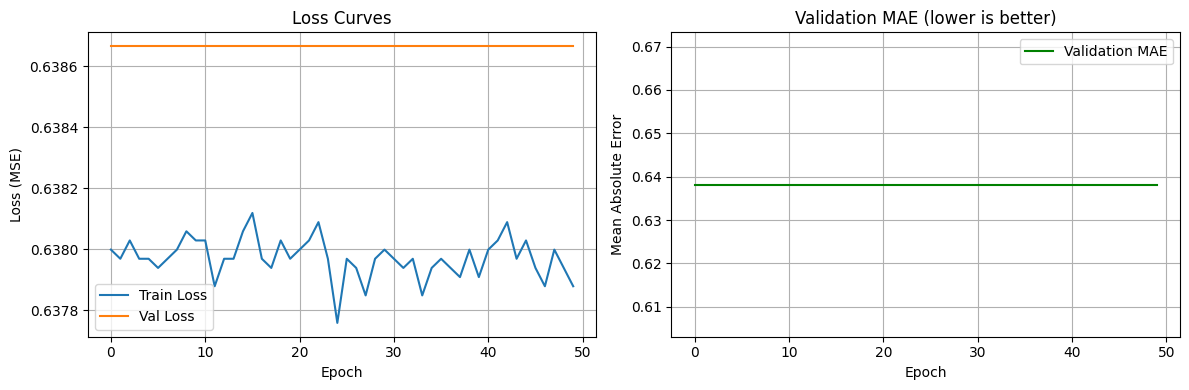

Final validation MAE: 0.638
=== CMV Architecture Comparison ===
Extracting features...
Setting up ConvoKit coordination analysis...
Filtering corpus using original paper criteria...
Original conversations: 3051
Filtered conversations: 2130
Retention rate: 69.8%
Creating filtered corpus for coordination analysis...
Using 235272 utterances for coordination analysis
Coordination analysis failed: 't1_cplsclz'
Using fallback: coordination scores will be set to 0.0
Extracting features from filtered conversations...
Successfully extracted 13871 features
Skipped 0 problematic utterances
Dataset: 13871 samples, 2 features

--- Testing 4 hidden neurons ---
Model parameters: 17
Training samples: 11096
Validation samples: 2775
Success rate: 63.8%
Training for 20 epochs...
Epoch  0: Train Loss = 0.6379, Val Loss = 0.6387, Val MAE = 0.638
Epoch  1: Train Loss = 0.6381, Val Loss = 0.6387, Val MAE = 0.638
Epoch  2: Train Loss = 0.6380, Val Loss = 0.6387, Val MAE = 0.638
Epoch  3: Train Loss = 0.6379, 

In [ ]:
# For single experiment with specific architecture:
model, trainer = run_basic_experiment()  # Uses default hidden_size=4

# For architecture comparison:
results, best_size = compare_architectures()  # Tests [4, 8, 16, 32]

# For detailed analysis of best architecture:
model = CMVPredictor(hidden_size=best_size)
# ... run longer training

Analyzing what the best model learned...


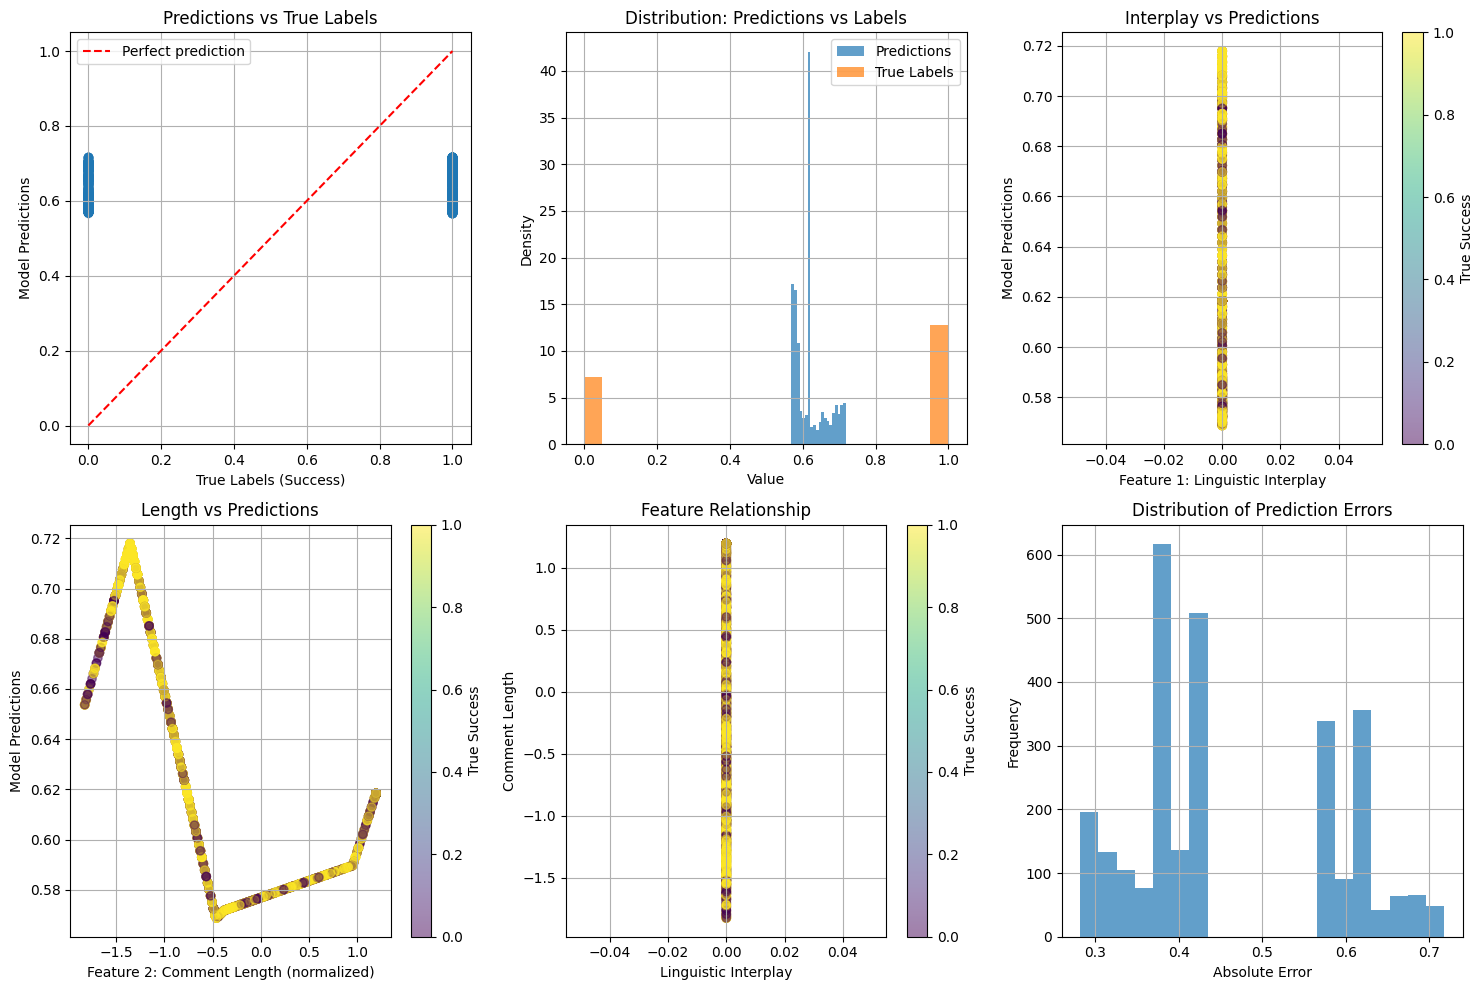

=== MODEL ANALYSIS ===
Validation MAE: 0.463
Prediction range: 0.569 to 0.718
Mean prediction: 0.621
Mean true label: 0.638
Label distribution: 63.8% successful arguments

=== FEATURE ANALYSIS ===
Interplay feature range: 0.000 to 0.000
Length feature range: -1.824 to 1.194
Mean interplay: 0.000
Mean length: 0.032

=== FEATURE IMPORTANCE ===
Interplay → Prediction correlation: nan
Length → Prediction correlation: -0.533
✓ Model using INTERPLAY more than length


In [ ]:
# Cell: Analyze what the 8-neuron model learned
print("Analyzing what the best model learned...")

# Use the results from your architecture comparison
best_architecture = 8  # We know this from your results

# Get the trained model from your results dictionary
model_8 = results[8]['trainer'].model  # Get the actual trained model
trainer_8 = results[8]['trainer']      # Get the trainer object

# Then analyze it
analysis_results = analyze_predictions(model_8, trainer_8)

# Plan:
First: Run your current run_basic_experiment() to see baseline
Then: Add the compare_architectures() function and run it
Finally: Use the best architecture for deeper analysis

1. ARCHITECTURE EXPERIMENTS:
   - Try 2 → 8 → 4 → 1 instead of 2 → 4 → 1
   - Try 2 → 16 → 8 → 4 → 1 (deeper network)
   - Add dropout: nn.Dropout(0.2)
   - Add batch normalization: nn.BatchNorm1d()

2. REGRESSION INSTEAD OF CLASSIFICATION:
   - Remove final Sigmoid activation
   - Use nn.MSELoss() instead of nn.BCELoss()
   - Output continuous persuasion scores

3. OPTIMIZATION EXPERIMENTS:
   - Try different learning rates: 0.1, 0.01, 0.001, 0.0001
   - Try different optimizers: SGD, RMSprop, AdamW
   - Add weight decay: optim.Adam(params, lr=0.001, weight_decay=1e-4)

4. DATA EXPERIMENTS:
   - Try different batch sizes: 16, 64, 128
   - Try different train/val splits: 0.1, 0.3
   - Remove standardization and see what happens

5. TRAINING IMPROVEMENTS:
   - Add early stopping when validation loss stops improving
   - Add learning rate scheduling
   - Save best model based on validation accuracy

QUESTIONS TO INVESTIGATE:
- What architecture gives best validation accuracy?
- Does regression work better than classification?
- What learning rate converges fastest?
- How much do different features matter?
"""

if __name__ == "__main__":
    model, trainer = run_basic_experiment()